In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
#import ulmo
import datetime as dt
from datetime import datetime
#from shapely.geometry import Point
#import metloom
#from metloom.pointdata import CDECPointData
#from metloom.pointdata import SnotelPointData
#from metloom.variables import CdecStationVariables
import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd
#import sklearn
#from sklearn.cluster import KMeans

import rioxarray as rxr
import xarray as xr
import rasterio as rio
import matplotlib
#import regionmask

### Read in auxiliary data sets

In [2]:
wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_31387/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [59]:
base_dir = '../data/reanalysis/swe/' 
fname_lst = []
## create list of netcdf files ##
years = list(sorted((f for f in os.listdir(base_dir) if not f.startswith(".")), key=str.lower))
for year in years:
    yr_dir = f'{base_dir}{year}/SWE_Post/'
    fname = os.listdir(yr_dir)[0]
    fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname_lst, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
ds['Year'] = np.arange(1990,2022)
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [77]:
anomalies = ds.SWE_Post - ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)
ds_stdev = ds.SWE_Post.std(dim='Year')
anomalies_sdev = anomalies / ds_stdev
anomalies_sdev_coarser = anomalies_sdev.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()

In [6]:
# def preprocess(ds):
#     ## set spatial reference ##
#     ds.rio.write_crs('EPSG:4326',inplace = True)
#     ds = ds.rio.set_spatial_dims('lon','lat',inplace=True)
#     return ds

# ars = xr.open_dataset('../data/dataverse_files/NCEP-NCAR/globalARcatalog_NCEP-NCAR_1948-2021_v3.0.nc')

In [7]:
# ars

### Read in AR data and subset lflocmap and shapemap variables

In [8]:
ars_lflat = xr.open_dataset('../data/dataverse_files/NCEP-NCAR/globalARcatalog_NCEP-NCAR_1948-2021_v3.0.nc')[['lflocmap','shapemap']].rio.write_crs('epsg:4326',inplace=True)

### Reassign longitude variable

In [9]:
ars_lflat.coords['lon'] = (ars_lflat.coords['lon'] + 180) % 360 - 180
ars_lflat = ars_lflat.sortby(ars_lflat.lon).rio.set_spatial_dims('lon','lat',inplace=True)

### Subset time

In [10]:
## years
ars_lflat = ars_lflat.sel(time=slice("1989-10-01", "2021-09-30"))
## months
def is_cold(month):
    return (month >= 1) & (month <= 4) | (month >= 11)

ars_lflat = ars_lflat.sel(time=is_cold(ars_lflat['time.month']))

In [11]:
ars_lflat

<xarray.Dataset>
Dimensions:      (ens: 1, time: 23200, lev: 1, lat: 73, lon: 144)
Coordinates:
  * lon          (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
  * ens          (ens) float64 1.0
    spatial_ref  int64 0
Data variables:
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [22]:
from shapely.geometry import Polygon, mapping

### wus bounds ###
xmin = -127
xmax = -105
ymin = 22.5
ymax = 49
lon_lat_list = [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin], [xmin, ymin]]
wus_bounds_geom = Polygon(lon_lat_list)
wus_bounds_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[wus_bounds_geom]) 

In [13]:
wus_bounds_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
ars_lflat.rio.crs

CRS.from_epsg(4326)

In [16]:
ars_lflat

<xarray.Dataset>
Dimensions:      (ens: 1, time: 23200, lev: 1, lat: 73, lon: 144)
Coordinates:
  * lon          (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
  * ens          (ens) float64 1.0
    spatial_ref  int64 0
Data variables:
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [23]:
ars_lflat_clp = ars_lflat.rio.set_spatial_dims('lon','lat',inplace=True).rio.clip(wus_bounds_gdf.geometry)

(23.0, 49.0)

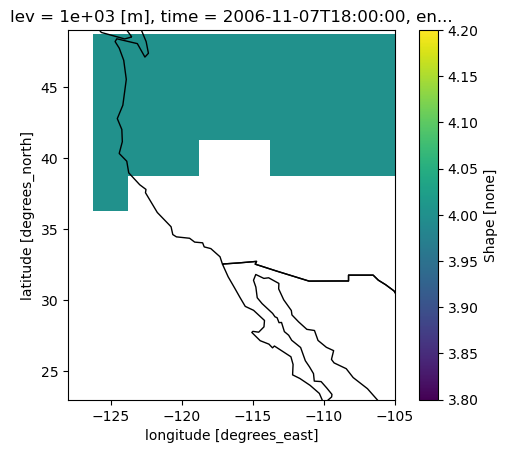

In [26]:
fig, ax = plt.subplots()
ars_lflat_clp.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
#clusters.where(clusters==4).plot(ax=ax)
world.plot(ax=ax,facecolor='none', edgecolor='k')
ax.set_xlim(-128,-105)
ax.set_ylim(23,49)

In [27]:
ars_lflat_clp

<xarray.Dataset>
Dimensions:      (lon: 9, lat: 11, lev: 1, time: 23200, ens: 1)
Coordinates:
  * lon          (lon) float64 -125.0 -122.5 -120.0 ... -110.0 -107.5 -105.0
  * lat          (lat) float64 22.5 25.0 27.5 30.0 32.5 ... 40.0 42.5 45.0 47.5
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
  * ens          (ens) float64 1.0
    spatial_ref  int64 0
Data variables:
    lflocmap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
    shapemap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

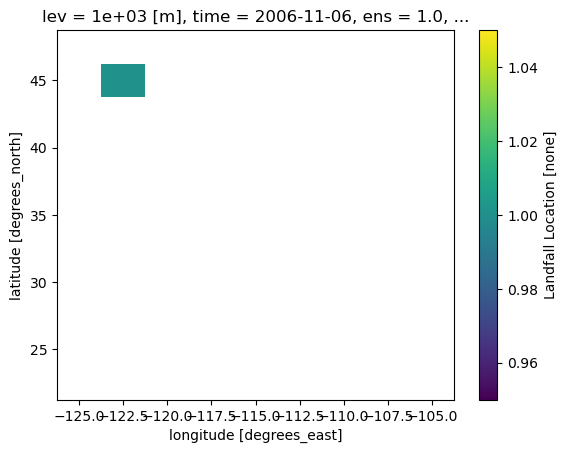

In [36]:
ars_lflat_clp.sel(time=slice("2006-11-06", "2006-11-07"))['lflocmap'][0,0,0,:,:].plot()

In [40]:
ars_lflat_clp.time.dt.year

<xarray.DataArray 'year' (time: 23200)>
array([1989, 1989, 1989, ..., 2021, 2021, 2021])
Coordinates:
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
    spatial_ref  int64 0
Attributes:
    standard_name:  time
    long_name:      time

In [65]:
ars_lflat_clp

<xarray.Dataset>
Dimensions:      (lon: 9, lat: 11, lev: 1, time: 23200, ens: 1)
Coordinates:
  * lon          (lon) float64 -125.0 -122.5 -120.0 ... -110.0 -107.5 -105.0
  * lat          (lat) float64 22.5 25.0 27.5 30.0 32.5 ... 40.0 42.5 45.0 47.5
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
  * ens          (ens) float64 1.0
    spatial_ref  int64 0
Data variables:
    lflocmap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
    shapemap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [64]:
anomalies_coarser[0]

<xarray.DataArray 'SWE_Post' (y: 506, x: 646)>
dask.array<getitem, shape=(506, 646), dtype=float32, chunksize=(506, 646), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.02 31.05 31.09 31.12 ... 48.87 48.9 48.94 48.97
  * x            (x) float64 -125.0 -124.9 -124.9 ... -102.1 -102.1 -102.0
    spatial_ref  int64 0
    Year         int64 1990

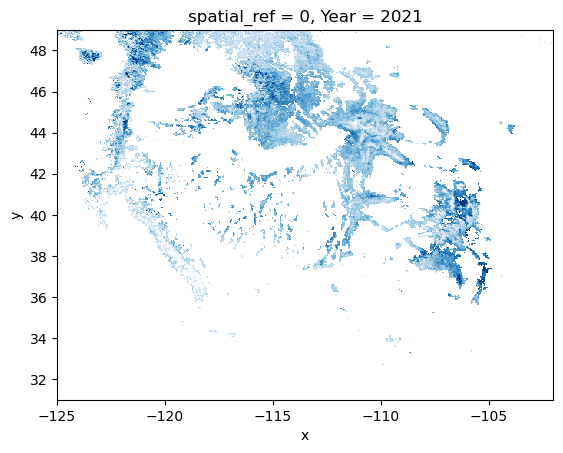

In [70]:
anomalies_coarser[31]


In [ ]:
yrs = [0,5]

for yr in yrs:
    fig,ax = plt.subplots(1,2,figsize=(10,3))
    # ars_lflat_clp.where((ars_lflat_clp.lat > 40) & (ars_lflat_clp.time.dt.year == yr))['lflocmap'].sum(dim = 'time')[0,0,:,:].plot(ax=ax)
    yr_ar = 2021 - yr
    yr_swe = 31 - yr
    ars_lflat_clp.where((ars_lflat_clp.time.dt.year == yr_ar))['lflocmap'].count(dim = 'time')[0,0,:,:].plot(ax=ax[0],vmax = 40)
    world.plot(ax=ax[0],facecolor='none', edgecolor='k')
    c = anomalies_sdev_coarser[yr_swe].plot(robust=True,cmap='RdBu', add_colorbar=False, vmin=-2,vmax=2)
    cb=plt.colorbar(c,orientation='vertical').set_label(label='SWE',size=20)
    plt.title(f'year = {yr_ar}')

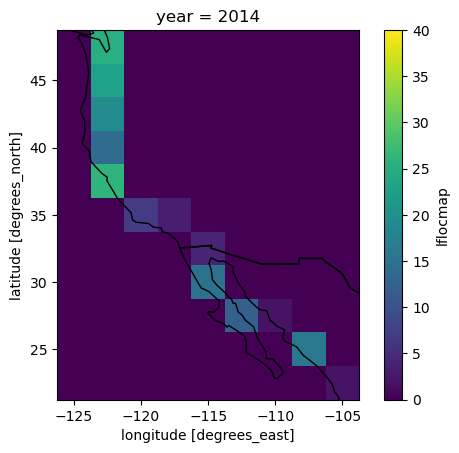

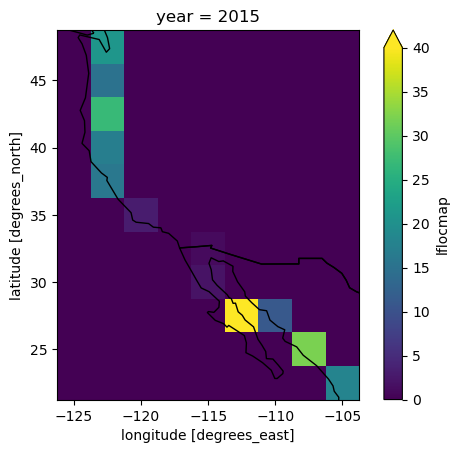

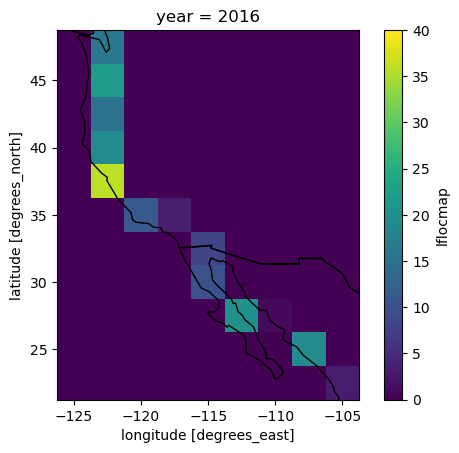

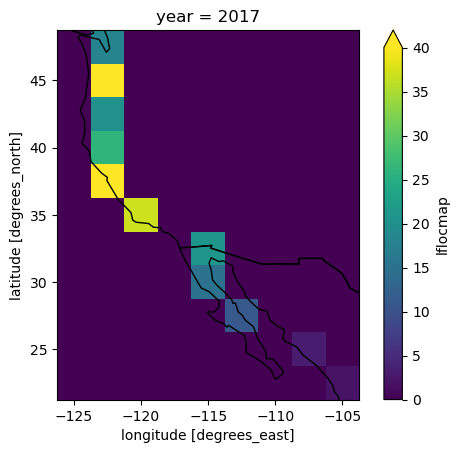

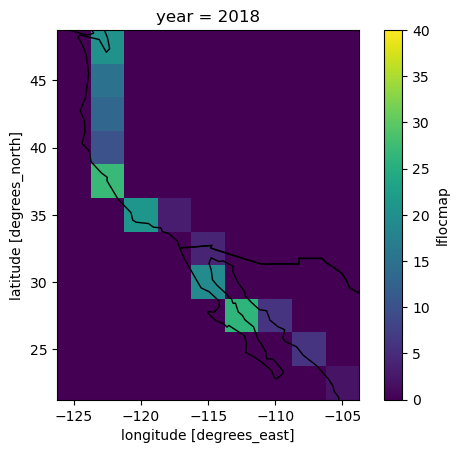

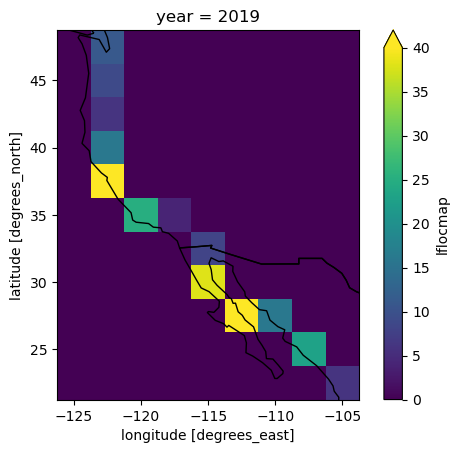

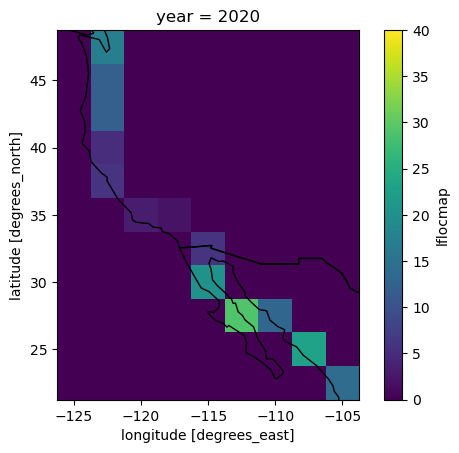

In [58]:
for yr in np.arange(2014,2021):
    fig,ax = plt.subplots()
    # ars_lflat_clp.where((ars_lflat_clp.lat > 40) & (ars_lflat_clp.time.dt.year == yr))['lflocmap'].sum(dim = 'time')[0,0,:,:].plot(ax=ax)
    ars_lflat_clp.where((ars_lflat_clp.time.dt.year == yr))['lflocmap'].count(dim = 'time')[0,0,:,:].plot(ax=ax,vmax = 40)
    world.plot(ax=ax,facecolor='none', edgecolor='k')
    plt.title(f'year = {yr}')

In [ ]:
# test out where the edge of the gridcells are
ars_lflat_clp.where((ars_lflat_clp.lat > 40) & (ars_lflat_clp.time.dt.year == 2006))['lflocmap'].sum(dim = 'time')[0,0,:,:].plot(ax=ax)

In [66]:
ars_lflat_clp

<xarray.Dataset>
Dimensions:      (lon: 9, lat: 11, lev: 1, time: 23200, ens: 1)
Coordinates:
  * lon          (lon) float64 -125.0 -122.5 -120.0 ... -110.0 -107.5 -105.0
  * lat          (lat) float64 22.5 25.0 27.5 30.0 32.5 ... 40.0 42.5 45.0 47.5
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1989-11-01 ... 2021-04-30T18:00:00
  * ens          (ens) float64 1.0
    spatial_ref  int64 0
Data variables:
    lflocmap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
    shapemap     (ens, time, lev, lat, lon) float32 nan nan nan ... nan nan nan
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [74]:
ars.coords['lon'] = (ars.coords['lon'] + 180) % 360 - 180
ars = ars.sortby(ars.lon)

In [84]:
ars = ars.rio.set_spatial_dims('lon','lat',inplace=True)

In [6]:
clusters = xr.open_dataset('../data/swe_reanalysis_5clusters.nc')
clusters = clusters.__xarray_dataarray_variable__

In [142]:
clusters

<xarray.DataArray '__xarray_dataarray_variable__' (y: 506, x: 646)>
[326876 values with dtype=float64]
Coordinates:
  * y        (y) float64 31.02 31.05 31.09 31.12 ... 48.87 48.9 48.94 48.97
  * x        (x) float64 -125.0 -124.9 -124.9 -124.9 ... -102.1 -102.1 -102.0

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6932/1047989789.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clusters.plot(cmap = plt.cm.get_cmap(cmap, 6), ax=ax, add_colorbar=True)


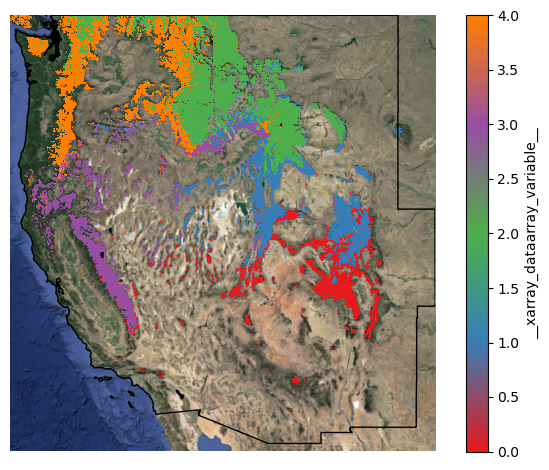

In [144]:
from matplotlib.colors import LinearSegmentedColormap
colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap = LinearSegmentedColormap.from_list('clusters', colors)
#cmap.set_bad('white',alpha=0)

fig, ax = plt.subplots()

clusters.plot(cmap = plt.cm.get_cmap(cmap, 6), ax=ax, add_colorbar=True)
ctx.add_basemap(ax=ax, crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
wstates_boundary.to_crs('epsg:4326').plot(ax=ax, facecolor='none',edgecolor='k')

plt.axis('off')
plt.tight_layout()

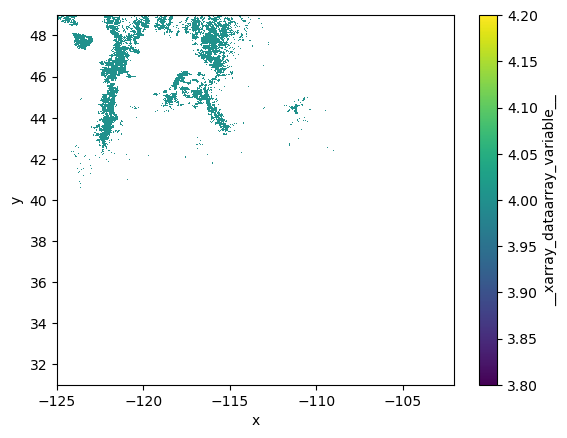

In [154]:
clusters.where(clusters==4).plot()

In [85]:
ars.sel(time=slice("1996-12-25", "1997-01-02")).rio.set_crs('epsg:4326')

<xarray.Dataset>
Dimensions:      (lon: 144, lat: 73, lev: 1, time: 36, ens: 1)
Coordinates:
  * lon          (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1996-12-25 ... 1997-01-02T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

<Axes: >

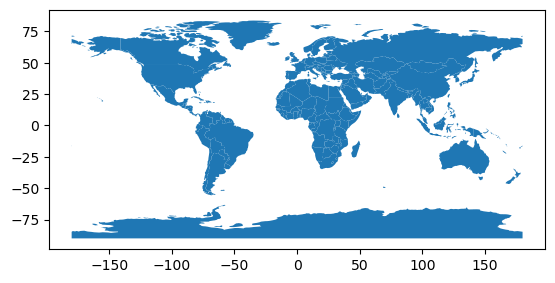

In [88]:
world.plot()

In [91]:
ars

<xarray.Dataset>
Dimensions:      (lon: 144, lat: 73, lev: 1, time: 108116, ens: 1)
Coordinates:
  * lon          (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [108]:
ars.sel(time=slice("1996-12-25", "1997-01-02"))['time'].values

array(['1996-12-25T00:00:00.000000000', '1996-12-25T06:00:00.000000000',
       '1996-12-25T12:00:00.000000000', '1996-12-25T18:00:00.000000000',
       '1996-12-26T00:00:00.000000000', '1996-12-26T06:00:00.000000000',
       '1996-12-26T12:00:00.000000000', '1996-12-26T18:00:00.000000000',
       '1996-12-27T00:00:00.000000000', '1996-12-27T06:00:00.000000000',
       '1996-12-27T12:00:00.000000000', '1996-12-27T18:00:00.000000000',
       '1996-12-28T00:00:00.000000000', '1996-12-28T06:00:00.000000000',
       '1996-12-28T12:00:00.000000000', '1996-12-28T18:00:00.000000000',
       '1996-12-29T00:00:00.000000000', '1996-12-29T06:00:00.000000000',
       '1996-12-29T12:00:00.000000000', '1996-12-29T18:00:00.000000000',
       '1996-12-30T00:00:00.000000000', '1996-12-30T06:00:00.000000000',
       '1996-12-30T12:00:00.000000000', '1996-12-30T18:00:00.000000000',
       '1996-12-31T00:00:00.000000000', '1996-12-31T06:00:00.000000000',
       '1996-12-31T12:00:00.000000000', '1996-12-31

(23.0, 49.0)

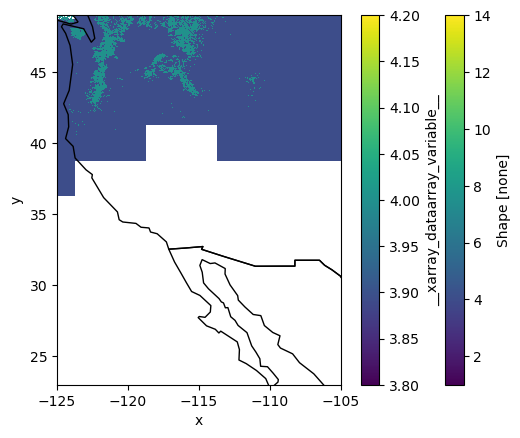

In [68]:
fig, ax = plt.subplots()
ars.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
clusters.where(clusters==4).plot(ax=ax)
world.plot(ax=ax,facecolor='none', edgecolor='k')
ax.set_xlim(-125,-105)
ax.set_ylim(23,49)
#print(ars.sel(time=slice("2006-11-06", "2006-11-07"))['time'].values)

In [69]:
from shapely.geometry import Polygon, mapping

### wus bounds ###
xmin = -125
xmax = -105
ymin = 22.5
ymax = 49
lon_lat_list = [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin], [xmin, ymin]]
wus_bounds_geom = Polygon(lon_lat_list)
wus_bounds_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[wus_bounds_geom]) 

<Axes: title={'center': 'lev = 1e+03 [m], time = 2006-11-07T18:00:00, en...'}, xlabel='lon', ylabel='latitude [degrees_north]'>

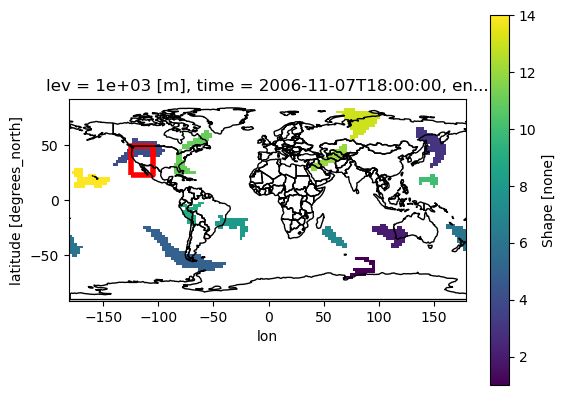

In [81]:
fig, ax = plt.subplots()

ars.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
wus_bounds_gdf.plot(ax=ax,facecolor='none',edgecolor='red',linewidth=4)
world.plot(ax=ax,facecolor='none', edgecolor='k')
#clusters.where(clusters==4).plot(ax=ax)

In [83]:
ars

<xarray.Dataset>
Dimensions:      (lon: 144, lat: 73, lev: 1, time: 108116, ens: 1)
Coordinates:
  * lon          (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [ ]:
# clipping AR dataset to the western us polygon
ars_crs = ars.rio.write_crs('epsg:4326')
ar_wus = ars_crs.rio.clip(wus_bounds_gdf.geometry)

In [ ]:
ar_lflat = ars_crs.lflat

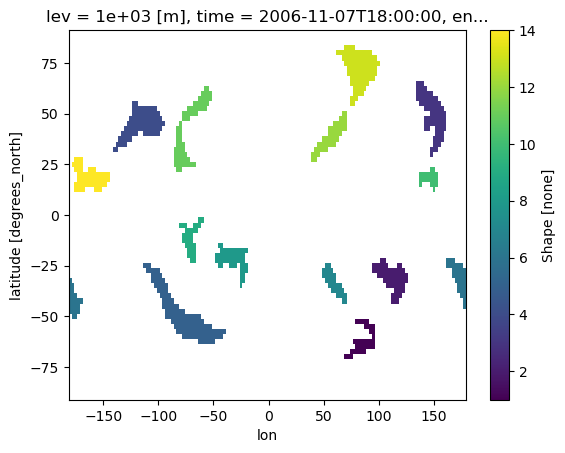

In [77]:
ars.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot()

['2021-11-10T00:00:00.000000000' '2021-11-10T06:00:00.000000000'
 '2021-11-10T12:00:00.000000000' '2021-11-10T18:00:00.000000000'
 '2021-11-11T00:00:00.000000000' '2021-11-11T06:00:00.000000000'
 '2021-11-11T12:00:00.000000000' '2021-11-11T18:00:00.000000000'
 '2021-11-12T00:00:00.000000000' '2021-11-12T06:00:00.000000000'
 '2021-11-12T12:00:00.000000000' '2021-11-12T18:00:00.000000000'
 '2021-11-13T00:00:00.000000000' '2021-11-13T06:00:00.000000000'
 '2021-11-13T12:00:00.000000000' '2021-11-13T18:00:00.000000000'
 '2021-11-14T00:00:00.000000000' '2021-11-14T06:00:00.000000000'
 '2021-11-14T12:00:00.000000000' '2021-11-14T18:00:00.000000000'
 '2021-11-15T00:00:00.000000000' '2021-11-15T06:00:00.000000000'
 '2021-11-15T12:00:00.000000000' '2021-11-15T18:00:00.000000000'
 '2021-11-16T00:00:00.000000000' '2021-11-16T06:00:00.000000000'
 '2021-11-16T12:00:00.000000000' '2021-11-16T18:00:00.000000000']


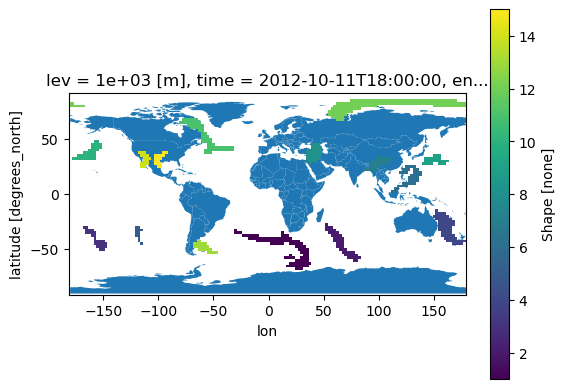

In [129]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("2012-10-10", "2012-10-16"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
print(ars.sel(time=slice("2021-11-10", "2021-11-16"))['time'].values)

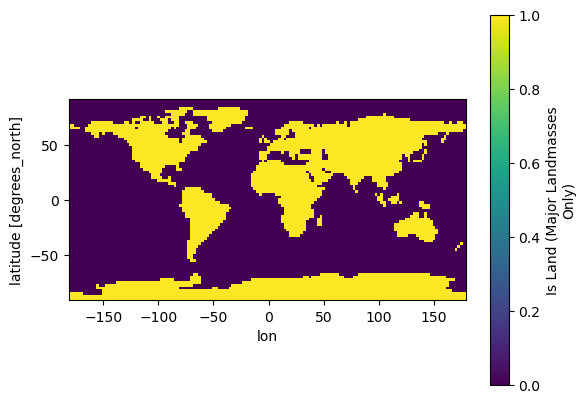

In [96]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['islnd'].rio.set_crs('epsg:4326').plot(ax=ax)

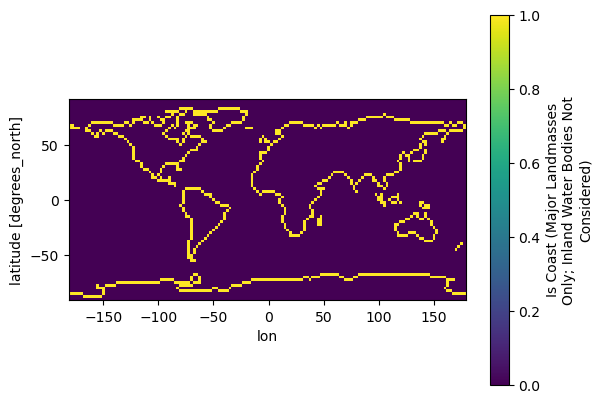

In [97]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['iscst'].rio.set_crs('epsg:4326').plot(ax=ax)


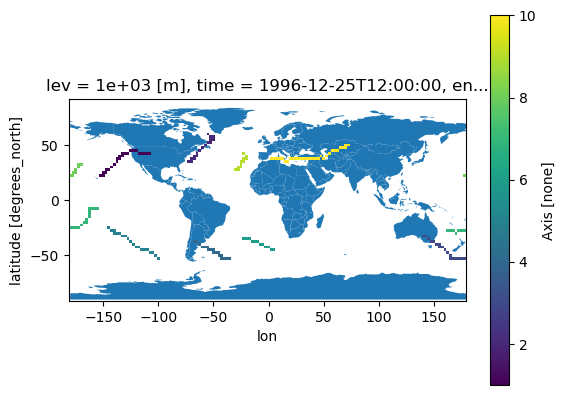

In [98]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['axismap'][0,2,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)

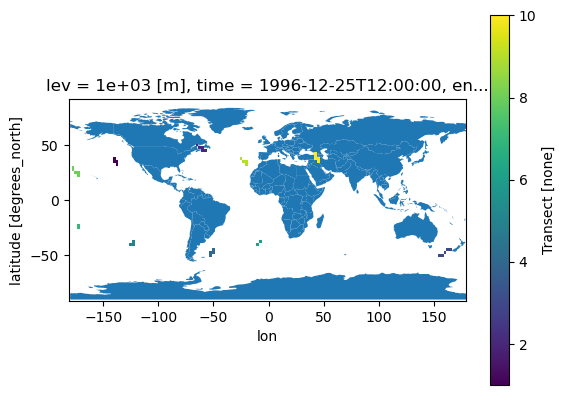

In [99]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['tnsctmap'][0,2,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)

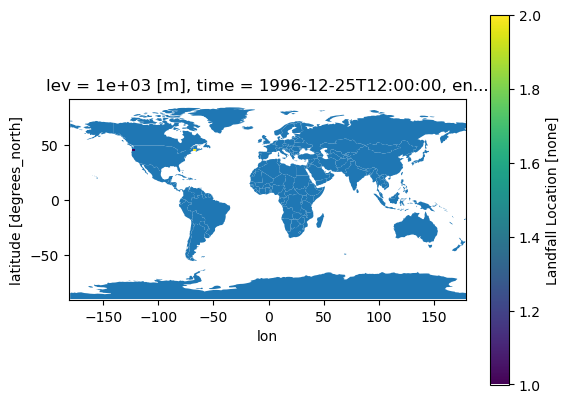

In [100]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['lflocmap'][0,2,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)

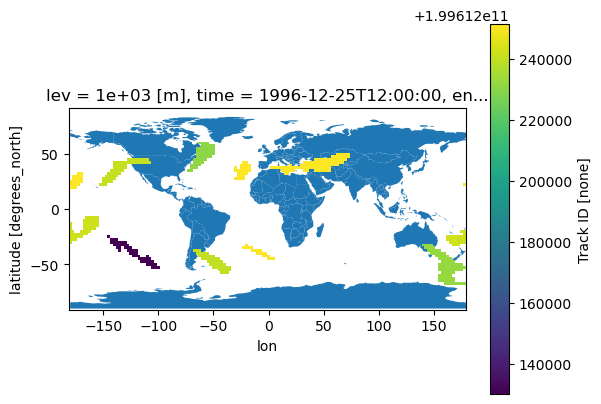

In [102]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['kidmap'][0,2,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)

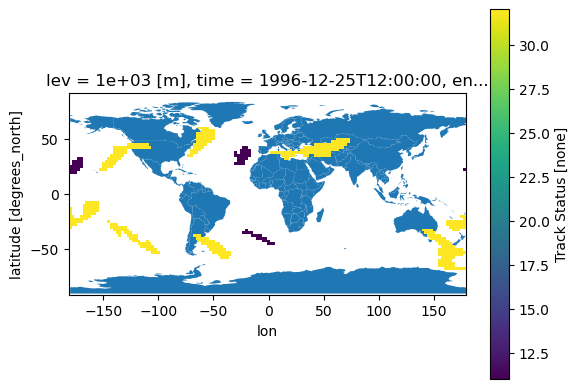

In [103]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['kstatusmap'][0,2,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)


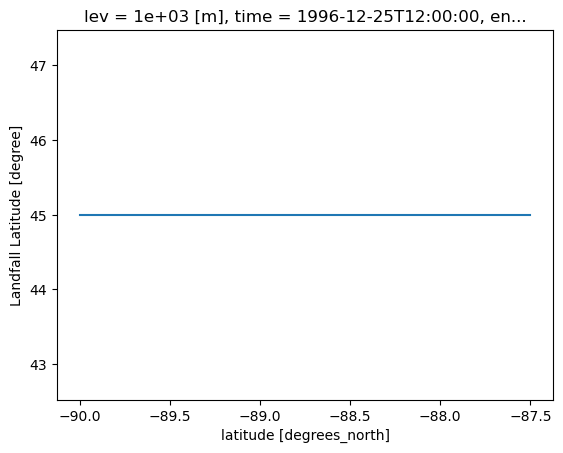

In [17]:
fig, ax = plt.subplots()
#world.plot(ax=ax)
ars.sel(time=slice("1996-12-25", "1997-01-02"))['lflat'][0,2,:,:].rio.set_crs('epsg:4326').plot(ax=ax)


In [23]:
ars.sel(time=slice("2016-10-01", "2017-09-30"))['lflat'][0,0,:,:].values

array([[-20.,  65.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan]], dtype=float32)

In [22]:
ars.sel(time=slice("2016-10-01", "2017-09-30"))['lflat'].values

array([[[[-20. ,  65. ,   nan, ...,   nan,   nan,   nan]],

        [[-70. ,  57.5, -20. , ...,   nan,   nan,   nan]],

        [[-70. , -20. ,  57.5, ...,   nan,   nan,   nan]],

        ...,

        [[ 45. ,  62.5,  77.5, ...,   nan,   nan,   nan]],

        [[-72.5,  62.5,  72.5, ...,   nan,   nan,   nan]],

        [[-67.5,  37.5,  42.5, ...,   nan,   nan,   nan]]]], dtype=float32)

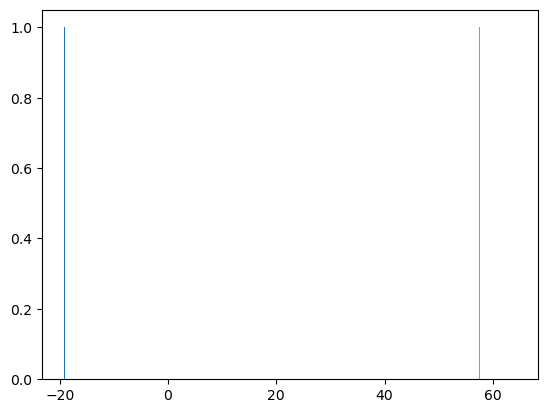

In [25]:
plt.hist(ars.sel(time=slice("2016-10-01", "2017-09-30"))['lflat'][0,:,:,:].values);

In [39]:
ars.sel(time=slice("1990-10-01", "2021-09-30"))['lflat'][0,:,0,:].groupby('time.year').count()

<xarray.DataArray 'lflat' (year: 32, lat: 73)>
array([[ 347,  281,  181, ...,    0,    0,    0],
       [1371, 1056,  640, ...,    0,    0,    0],
       [1391, 1073,  619, ...,    0,    0,    0],
       ...,
       [1377, 1134,  761, ...,    0,    0,    0],
       [1393, 1151,  741, ...,    0,    0,    0],
       [1036,  816,  512, ...,    0,    0,    0]])
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
    lev      float64 1e+03
    ens      float64 1.0
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2017 2018 2019 2020 2021
Attributes:
    long_name:  Landfall Latitude
    units:      degree

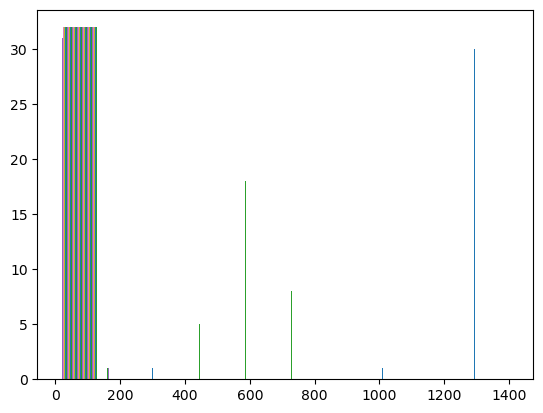

In [40]:
plt.hist(ars.sel(time=slice("1990-10-01", "2021-09-30"))['lflat'][0,:,0,:].groupby('time.year').count());

In [41]:
# season slicing code from: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months

def is_cold(month):
    return (month >= 1) & (month <= 4) | (month >= 11)

ars_cold = ars.sel(time=is_cold(ars['time.month']))

['2021-11-10T00:00:00.000000000' '2021-11-10T06:00:00.000000000'
 '2021-11-10T12:00:00.000000000' '2021-11-10T18:00:00.000000000'
 '2021-11-11T00:00:00.000000000' '2021-11-11T06:00:00.000000000'
 '2021-11-11T12:00:00.000000000' '2021-11-11T18:00:00.000000000'
 '2021-11-12T00:00:00.000000000' '2021-11-12T06:00:00.000000000'
 '2021-11-12T12:00:00.000000000' '2021-11-12T18:00:00.000000000'
 '2021-11-13T00:00:00.000000000' '2021-11-13T06:00:00.000000000'
 '2021-11-13T12:00:00.000000000' '2021-11-13T18:00:00.000000000'
 '2021-11-14T00:00:00.000000000' '2021-11-14T06:00:00.000000000'
 '2021-11-14T12:00:00.000000000' '2021-11-14T18:00:00.000000000'
 '2021-11-15T00:00:00.000000000' '2021-11-15T06:00:00.000000000'
 '2021-11-15T12:00:00.000000000' '2021-11-15T18:00:00.000000000'
 '2021-11-16T00:00:00.000000000' '2021-11-16T06:00:00.000000000'
 '2021-11-16T12:00:00.000000000' '2021-11-16T18:00:00.000000000']


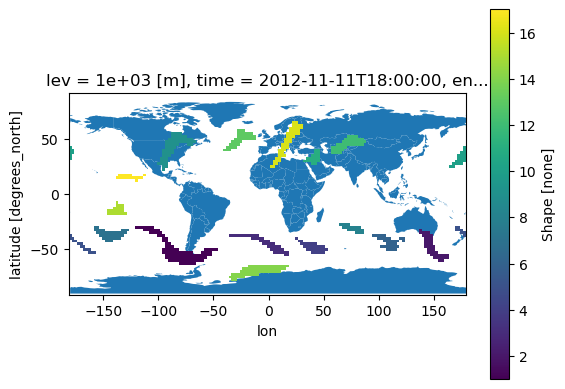

In [9]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars_cold.sel(time=slice("2012-11-10", "2012-11-16"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
print(ars.sel(time=slice("2021-11-10", "2021-11-16"))['time'].values)

In [42]:
# ax.set_xlim(-125,-105)
# ax.set_ylim(31,49)

ars_cold_western = ars_cold.sel(lon=slice(-125, -105), lat=slice(31, 49))

['1991-11-10T00:00:00.000000000' '1991-11-10T06:00:00.000000000'
 '1991-11-10T12:00:00.000000000' '1991-11-10T18:00:00.000000000'
 '1991-11-11T00:00:00.000000000' '1991-11-11T06:00:00.000000000'
 '1991-11-11T12:00:00.000000000' '1991-11-11T18:00:00.000000000'
 '1991-11-12T00:00:00.000000000' '1991-11-12T06:00:00.000000000'
 '1991-11-12T12:00:00.000000000' '1991-11-12T18:00:00.000000000'
 '1991-11-13T00:00:00.000000000' '1991-11-13T06:00:00.000000000'
 '1991-11-13T12:00:00.000000000' '1991-11-13T18:00:00.000000000'
 '1991-11-14T00:00:00.000000000' '1991-11-14T06:00:00.000000000'
 '1991-11-14T12:00:00.000000000' '1991-11-14T18:00:00.000000000'
 '1991-11-15T00:00:00.000000000' '1991-11-15T06:00:00.000000000'
 '1991-11-15T12:00:00.000000000' '1991-11-15T18:00:00.000000000'
 '1991-11-16T00:00:00.000000000' '1991-11-16T06:00:00.000000000'
 '1991-11-16T12:00:00.000000000' '1991-11-16T18:00:00.000000000']


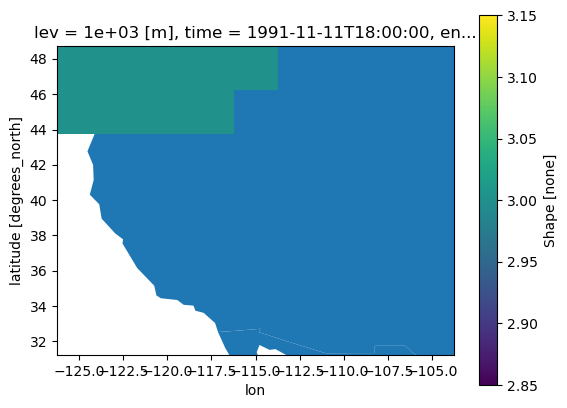

In [15]:
fig, ax = plt.subplots()
world.plot(ax=ax)
ars_cold_western.sel(time=slice("1991-11-10", "1991-11-16"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
print(ars_cold_western.sel(time=slice("1991-11-10", "1991-11-16"))['time'].values)

In [43]:
# season slicing code from: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months

def years(year):
    return (year >= 1990)

ars_cold_30 = ars_cold_western.sel(time=years(ars_cold_western['time.year']))

In [19]:
ars_cold_30

<xarray.Dataset>
Dimensions:      (lon: 9, lat: 7, lev: 1, time: 23200, ens: 1)
Coordinates:
  * lon          (lon) float64 -125.0 -122.5 -120.0 ... -110.0 -107.5 -105.0
  * lat          (lat) float64 32.5 35.0 37.5 40.0 42.5 45.0 47.5
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1990-01-01 ... 2021-12-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [20]:
ars_cold_30.shapemap

<xarray.DataArray 'shapemap' (ens: 1, time: 23200, lev: 1, lat: 7, lon: 9)>
[1461600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -125.0 -122.5 -120.0 -117.5 ... -110.0 -107.5 -105.0
  * lat      (lat) float64 32.5 35.0 37.5 40.0 42.5 45.0 47.5
  * lev      (lev) float64 1e+03
  * time     (time) datetime64[ns] 1990-01-01 ... 2021-12-31T18:00:00
  * ens      (ens) float64 1.0
Attributes:
    long_name:  Shape
    units:      none

In [60]:
ars_cold_30['lflat'][0,:,0,:].groupby('time.year')

DataArrayGroupBy, grouped over 'year'
32 groups with labels 1990, 1991, 1992, ..., 2020, 2021.

In [58]:
ars_cold_30['lflat'].values

array([[[[nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

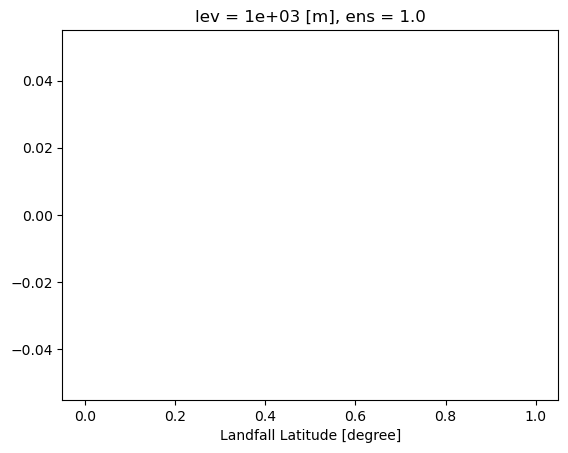

In [57]:
xr.plot.hist(ars_cold_30['lflat'])

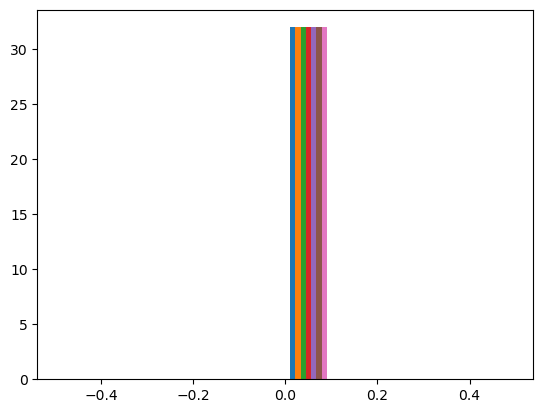

In [44]:
plt.hist(ars_cold_30['lflat'][0,:,0,:].groupby('time.year').count());

type: len() of unsized object

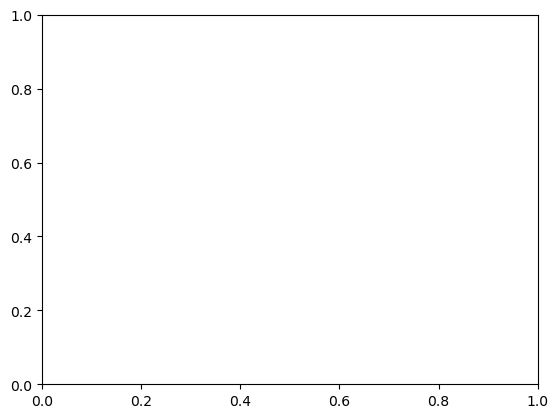

In [66]:
plt.hist(ars_cold_30.sel(time = slice('1990-10-01','1991-09-30'))['lflat'][0,:,0,:].count());

In [61]:
import plotly.express as px

In [64]:
fig = px.density_heatmap(ars_cold_30["lflat"][0,:,0,:], x="lflat", y="time.year")
fig.show()

type: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5] but received: lflat

In [25]:
interp = ars_cold_western.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'].interp(lat=clusters["y"], lon=clusters["x"], method='linear')

In [14]:
interp

<xarray.DataArray 'shapemap' (ens: 1, time: 8, lev: 1, y: 506, x: 646)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
...
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * lev      (lev) float64 1e+03
  * time     (time) datetime64[ns] 1991-11-10 ... 1991-11-11T18:00:00
  * ens      (ens) float64 1.0
    lat      (y) float64 31.02 31.05 31.09 31.12 ... 48.87 48.9 48.94 48.97
    lon      (x) float64 -125.0 -124.9 -124.9 -124.9 ... -102.1 -102.1 -102.0
  * y        (y) float64 31.02 31.05 31.09 31.12 ... 48.87 48.9 48.94 48.97
  * x        (x) float64 -125.0 -124.9 -124.9 -124.9 ... -102.1 -102.1 -102.0
Attributes:
    long_name:  Shape
    units:      none

['2006-11-06T00:00:00.000000000' '2006-11-06T06:00:00.000000000'
 '2006-11-06T12:00:00.000000000' '2006-11-06T18:00:00.000000000'
 '2006-11-07T00:00:00.000000000' '2006-11-07T06:00:00.000000000'
 '2006-11-07T12:00:00.000000000' '2006-11-07T18:00:00.000000000']


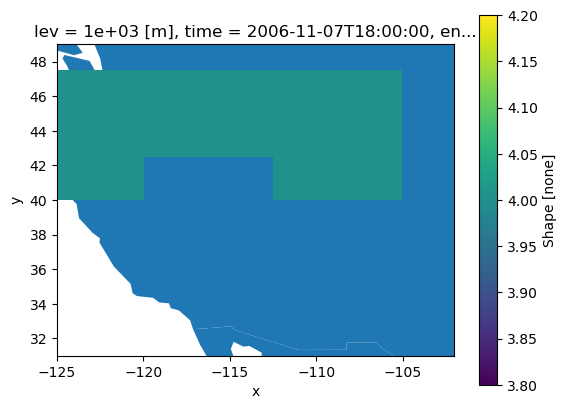

In [26]:
fig, ax = plt.subplots()
world.plot(ax=ax)
interp[0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
print(interp.time.values)

['2006-11-06T00:00:00.000000000' '2006-11-06T06:00:00.000000000'
 '2006-11-06T12:00:00.000000000' '2006-11-06T18:00:00.000000000'
 '2006-11-07T00:00:00.000000000' '2006-11-07T06:00:00.000000000'
 '2006-11-07T12:00:00.000000000' '2006-11-07T18:00:00.000000000']


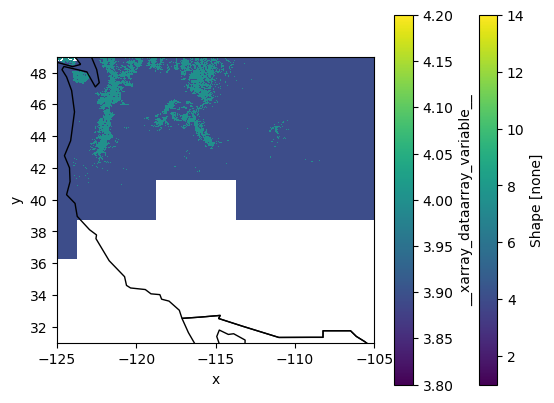

In [21]:
fig, ax = plt.subplots()
ars.sel(time=slice("2006-11-06", "2006-11-07"))['shapemap'][0,7,0,:,:].rio.set_crs('epsg:4326').plot(ax=ax)
clusters.where(clusters==4).plot(ax=ax)
world.plot(ax=ax,facecolor='none', edgecolor='k')
ax.set_xlim(-125,-105)
ax.set_ylim(31,49)
print(ars.sel(time=slice("2006-11-06", "2006-11-07"))['time'].values)

My interpolation attempts aren't working, probably because of nan values? Ask Ross how to do some sort of overlap method that would give higher-resolution cells from 'clusters' a new variable with data from overlapping cells from ARs. This method should accomodate nan values within each time step at different locations.

In [ ]:
interp_ars = ars_cold_30.shapemap.interp(lat=clusters["y"], lon=clusters["x"])

In [22]:
ars

<xarray.Dataset>
Dimensions:      (lon: 144, lat: 73, lev: 1, time: 108116, ens: 1)
Coordinates:
  * lon          (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat          (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.04.04
    creation_date:         04-Apr-2022 15:52:41
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [21]:
ars.time.values[0]

numpy.datetime64('1948-01-01T00:00:00.000000000')

In [ ]:
ars.sel(time=slice("1996-12-25", "1997-01-02"))

In [32]:
ars.shapemap.values.T[0].plot()

type: 'numpy.ndarray' object has no attribute 'plot'

In [55]:
ars = ars.drop_indexes(['lev','ens','time'])
ars = ars.reset_coords(names=['lev','ens'])

In [56]:
ars_shapemap = ars.shapemap.T

In [57]:
ars_shapemap

<xarray.DataArray 'shapemap' (lon: 144, lat: 73, lev: 1, time: 108116, ens: 1)>
[1136515392 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
    time     (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
Dimensions without coordinates: lev, ens
Attributes:
    long_name:  Shape
    units:      none

In [59]:
ars_shapemap_0 = ars_shapemap[0]

In [60]:
ars_shapemap_0

<xarray.DataArray 'shapemap' (lat: 73, lev: 1, time: 108116, ens: 1)>
[7892468 values with dtype=float32]
Coordinates:
    lon      float64 0.0
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
    time     (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
Dimensions without coordinates: lev, ens
Attributes:
    long_name:  Shape
    units:      none

type: pcolormesh() takes 1 or 3 positional arguments but 2 were given

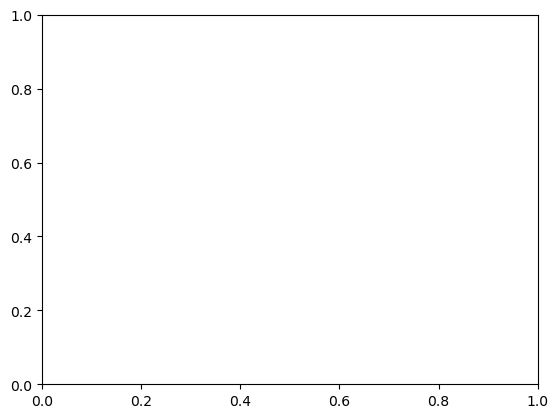

In [63]:
fig, ax = plt.subplots()
ax.pcolormesh(ars_shapemap_0['lon'], ars_shapemap_0['lat'])

In [18]:
ars_shapefile = ars['shapemap']

In [37]:
ars_shapefile = ars_shapefile.T

In [39]:
ars_shapefile

<xarray.DataArray 'shapemap' (lon: 144, lat: 73, lev: 1, time: 108116, ens: 1)>
[1136515392 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lev      (lev) float64 1e+03
  * time     (time) datetime64[ns] 1948-01-01 ... 2021-12-31T18:00:00
  * ens      (ens) float64 1.0
Attributes:
    long_name:  Shape
    units:      none

In [21]:
ars_shapefile = ars_shapefile.rio.set_spatial_dims('lon','lat',inplace=True)

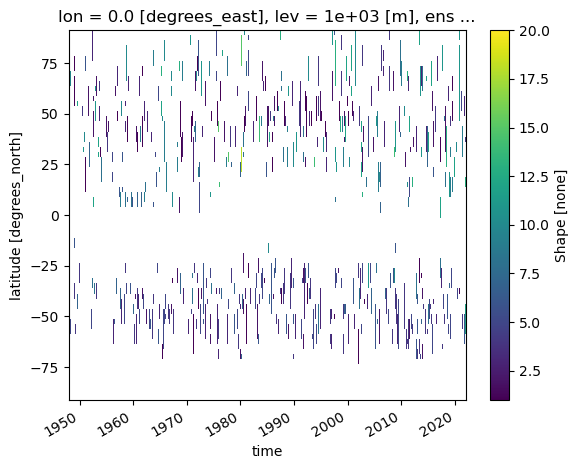

In [38]:
ars_shapefile[0].plot()

(array([7.171219e+06, 4.079976e+06, 3.354622e+06, 3.013786e+06,
        2.440338e+06, 1.360844e+06, 4.768050e+05, 9.626000e+04,
        1.212400e+04, 1.051000e+03]),
 array([ 1.00001,  3.10002,  5.20003,  7.30004,  9.40005, 11.50006,
        13.60007, 15.70008, 17.80009, 19.9001 , 22.00011]),
 <BarContainer object of 10 artists>)

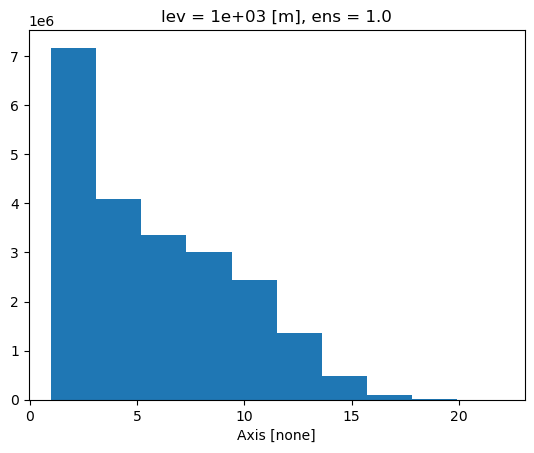

In [27]:
ars.axismap[0].plot()

<Axes: >

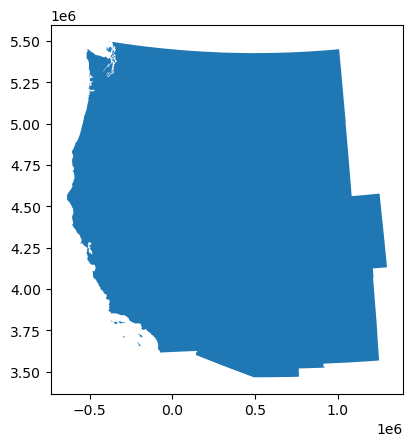

In [6]:
wstates_boundary.plot()

type: tuple index out of range

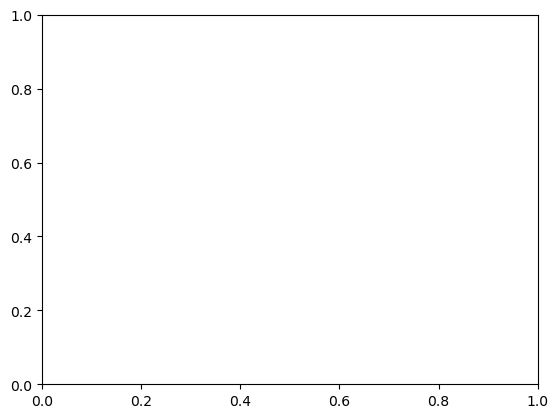

In [34]:
fig, ax = plt.subplots()
ax.pcolormesh(ars['lon'][0], ars['lat'][0], ars['shapemap'][0])